In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip
'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline
'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from numpy.testing import assert_array_almost_equal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [2]:
# Load datasets
file = 'datasets/credit_card_data/credit_card.csv'
data = pd.read_csv(file)
dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
X_train, X_test, y_train, y_test = \
train_test_split(dataX, dataY, test_size=0.33, \
random_state=2018, stratify=dataY)

In [3]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [5]:
# Evaluation Metrics
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
    average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))
    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
    preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    if returnPreds==True:
        return preds

In [6]:
# plot
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
    data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

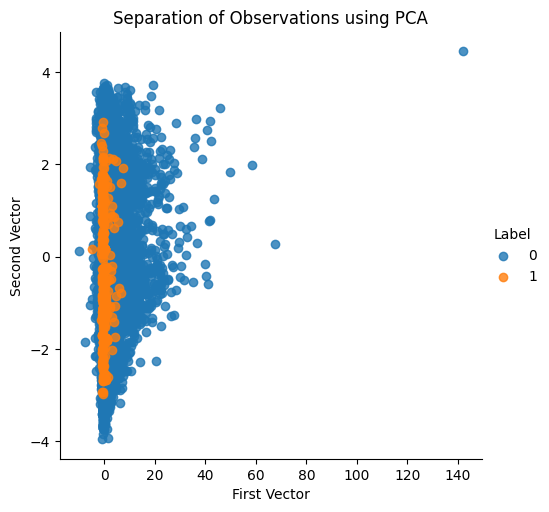

In [7]:
# 30 principal components

# Apply PCA to create 30 components (well that is equal to the original number of features) 
# and then reconstruct them

from sklearn.decomposition import PCA
n_components = 30
whiten = False
random_state = 2018
pca = PCA(n_components=n_components, whiten=whiten, \
random_state=random_state)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
index=X_train.index)
scatterPlot(X_train_PCA, y_train, "PCA")

In [10]:
X_train_PCA_inverse

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
142087,-0.215609,-1.011878,1.170867,0.201381,-0.252129,-0.386390,-0.049420,-0.192587,0.932578,-0.220587,...,0.238737,-0.233631,-0.783226,0.157078,-0.586703,-0.161425,0.230941,0.525280,0.473651,-0.297296
165168,0.472353,0.072173,0.665164,-0.241837,-0.380205,0.699456,-0.634194,0.838470,-0.137344,-0.167262,...,0.098082,-0.446548,-1.039925,0.148460,1.079003,-0.761713,0.220597,0.564453,0.262996,-0.337757
235908,1.132435,0.099579,-0.389819,-0.944884,-1.492064,-0.090536,-0.879539,1.260059,-0.577069,-2.758547,...,0.135386,0.615087,2.051663,0.537784,1.887247,-0.950002,0.194730,0.394588,0.814038,0.499962
148255,-0.109161,0.015623,0.520260,0.191791,-0.418058,0.320155,-0.775673,0.821509,-0.159150,-0.060892,...,-0.039324,-0.342336,-0.740217,0.130539,-0.027853,-0.956686,0.296304,0.619910,0.294929,-0.329281
145672,-0.161996,0.009169,0.524802,0.173686,-0.334556,0.766454,0.505087,0.267757,0.189101,-0.186534,...,0.107825,-0.201647,-0.456069,0.049791,-0.727602,-2.183860,-0.148240,0.585847,0.762249,-0.333279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30023,-1.243910,-0.249496,0.101075,0.909879,-0.688839,-0.389697,-0.969098,0.404471,-0.295909,-1.322352,...,0.115211,0.369245,1.209182,-0.066533,1.627214,0.628748,-0.301789,-0.110189,0.057551,-0.241283
195475,0.763626,-0.254091,-2.756705,-2.082848,0.720192,-0.770847,0.043816,1.347183,-0.309383,0.281819,...,3.172416,1.379262,-0.221650,-1.822138,0.611275,-0.865244,1.296414,-0.902976,0.455664,5.005845
48687,-1.075467,0.106034,-1.131050,-0.470366,0.156445,-0.553642,-0.376423,0.654146,-0.283678,0.204805,...,1.498658,0.098597,-1.586216,-0.825029,-0.620769,0.109427,1.733472,-0.501687,0.300189,2.041624
159608,0.376982,0.055698,0.496830,-0.098914,-0.582971,0.647489,-0.393782,0.810516,-0.116346,0.031466,...,0.002229,-0.444765,-1.058758,-0.074376,-1.672445,-0.672678,0.420560,0.603711,0.263881,-0.320925


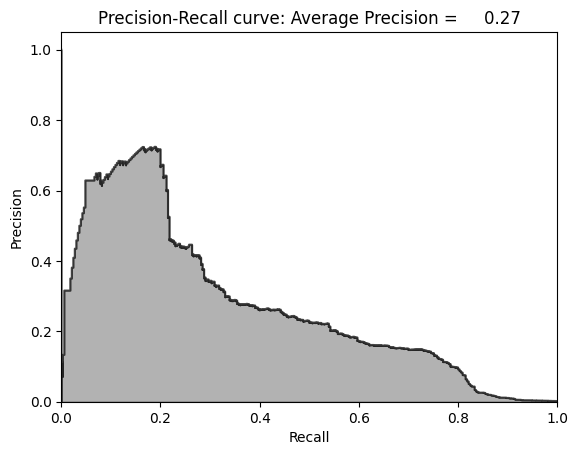

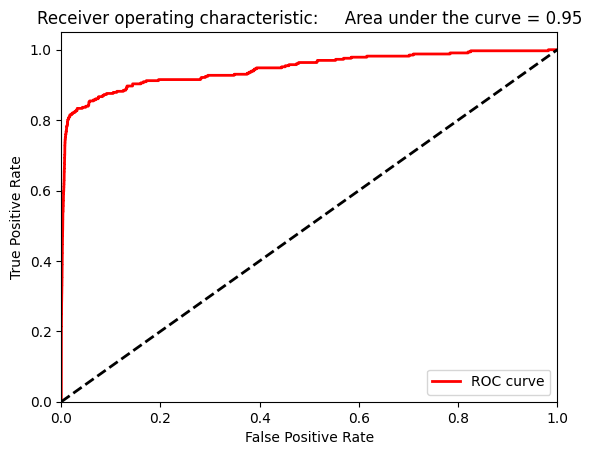

In [12]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [13]:
# No idea why but above graphs show that algo showed poor performance

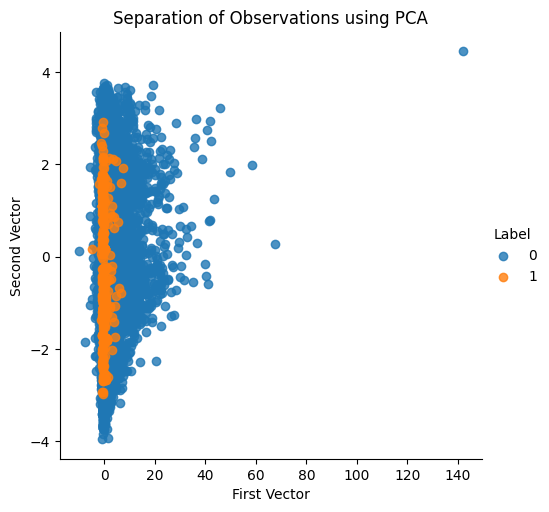

In [14]:
from sklearn.decomposition import PCA
n_components = 27
whiten = False
random_state = 2018
pca = PCA(n_components=n_components, whiten=whiten, \
random_state=random_state)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
index=X_train.index)
scatterPlot(X_train_PCA, y_train, "PCA")

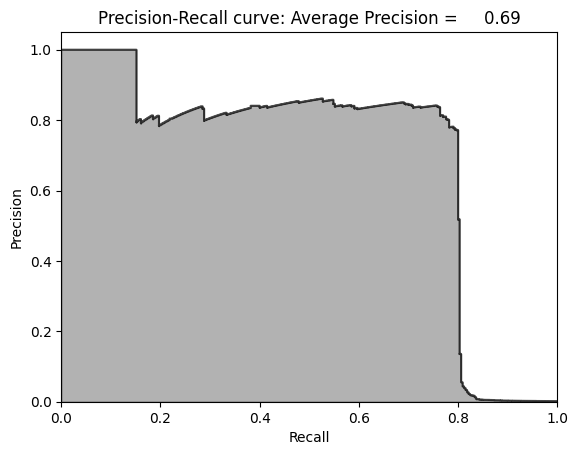

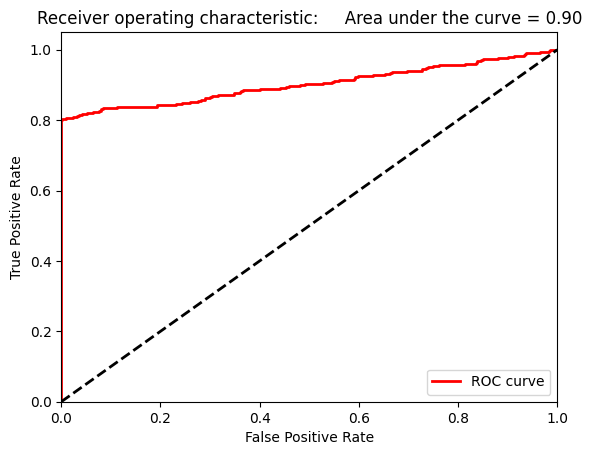

In [15]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [17]:
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))

Precision:  0.75
Recall:  0.8


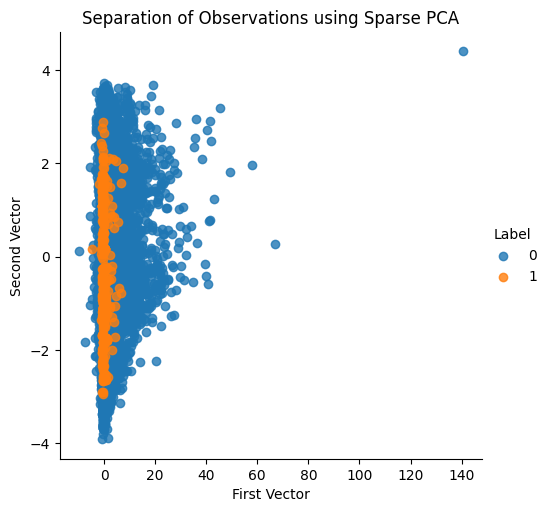

In [18]:
# Sparse PCA
from sklearn.decomposition import SparsePCA
n_components = 27
alpha = 0.0001
random_state = 2018
n_jobs = -1
sparsePCA = SparsePCA(n_components=n_components, \
alpha=alpha, random_state=random_state, n_jobs=n_jobs)
sparsePCA.fit(X_train.loc[:,:])
X_train_sparsePCA = sparsePCA.transform(X_train)
X_train_sparsePCA = pd.DataFrame(data=X_train_sparsePCA, index=X_train.index)
scatterPlot(X_train_sparsePCA, y_train, "Sparse PCA")

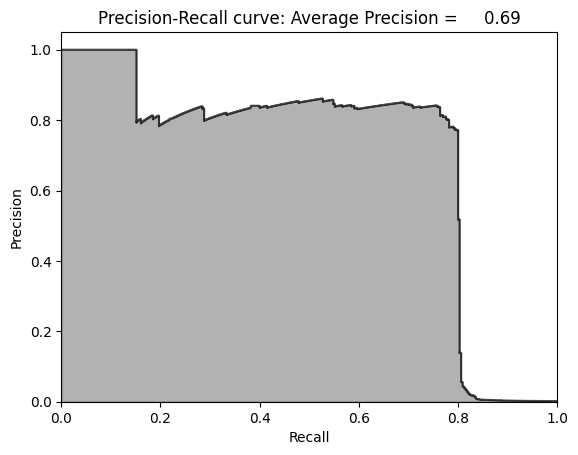

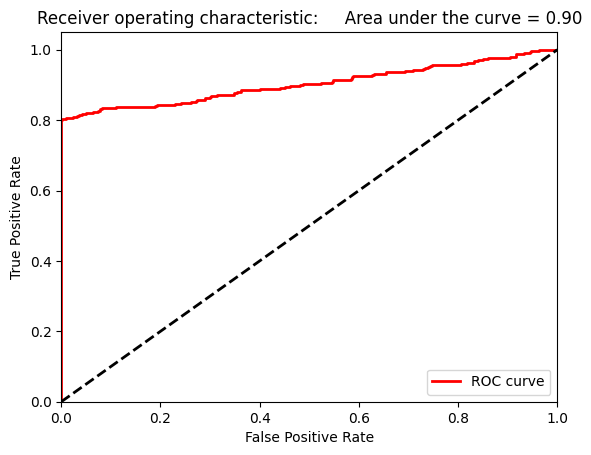

In [19]:
X_train_sparsePCA_inverse = np.array(X_train_sparsePCA). \
dot(sparsePCA.components_) + np.array(X_train.mean(axis=0))
X_train_sparsePCA_inverse = \
pd.DataFrame(data=X_train_sparsePCA_inverse, index=X_train.index)
anomalyScoresSparsePCA = anomalyScores(X_train, X_train_sparsePCA_inverse)
preds = plotResults(y_train, anomalyScoresSparsePCA, True)